## Example: Stitching of micrographs from a lab source

Data collected at ...

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

### 1. Load the data

In [2]:
data_path = "/home/iat69393/scratch/stitching-paper/lab_microradiograph_data.h5"
dark = 99.
with h5py.File(data_path, "r") as f:
    data = f['data'][:, :, :2048] - dark
    flat = f['flat'][:, :2048] - dark

### 2. Generate masks to eliminate bad pixels

In [4]:
mad = lambda a: np.median(np.abs(a - np.median(a))) * 1.4826
mask_threshold = 2.5*mad(flat)
mask_medfilt_size = 20
mf = ndi.median_filter(flat, mask_medfilt_size)
mask = np.abs(flat-mf) < mask_threshold
masks = [mask for i in range(len(data))]

### Run stitching algorithm with downsample=4

In [5]:
ds = 4
d0 = ndi.zoom(data, zoom=(1, 1./ds, 1./ds))
f0 = ndi.zoom(flat, zoom=(1./ds, 1./ds))
m0 = ndi.zoom(mask*1., zoom=(1./ds, 1./ds))>.8

In [18]:
import afstitch
afs0 = afstitch.AlignFactorStitch(d0, shifts=None, scalar=f0, mask=m0, max_shift=20)
afs0.solve(refine_scalar=False, max_iter=5)

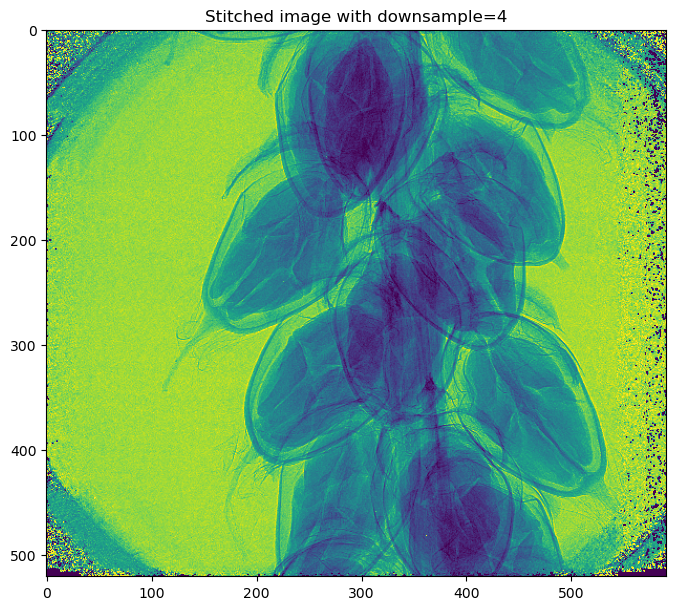

In [19]:
plt.figure(figsize=(8,8))
plt.title("Stitched image with downsample=4")
plt.imshow(afs0.stitched, vmin=np.percentile(afs0.stitched,1), vmax=np.percentile(afs0.stitched,99))
plt.show()

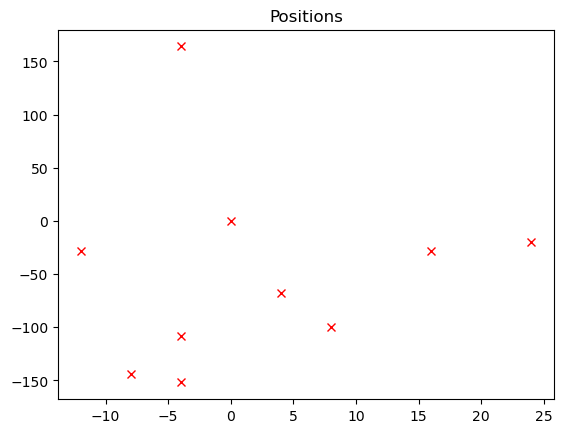

In [29]:
plt.figure()
plt.title("Positions")
plt.plot(afs0.shifts[:,0]*4, afs0.shifts[:,1]*4, 'rx')
plt.show()

### Run stitching algorithm with downsampl=2

In [17]:
ds = 2
d1 = ndi.zoom(data, zoom=(1, 1./ds, 1./ds))
f1 = ndi.zoom(flat, zoom=(1./ds, 1./ds))
m1 = ndi.zoom(mask*1., zoom=(1./ds, 1./ds))>.8

In [24]:
afs1 = afstitch.AlignFactorStitch(d1, shifts=afs0.shifts*2, scalar=f1, mask=m1, max_shift=20)
afs1.solve(refine_scalar=False, max_iter=5)

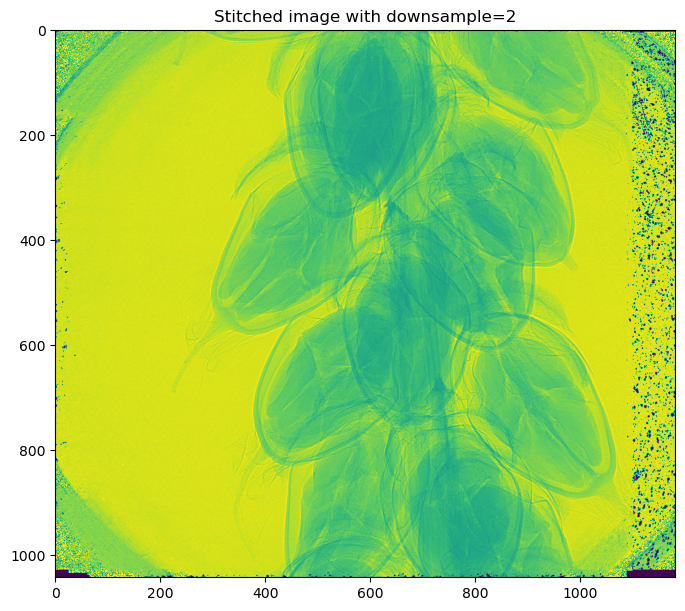

In [25]:
plt.figure(figsize=(8,8))
plt.title("Stitched image with downsample=2")
plt.imshow(afs1.stitched, vmin=np.percentile(afs1.stitched,1), vmax=np.percentile(afs1.stitched,99))
plt.show()

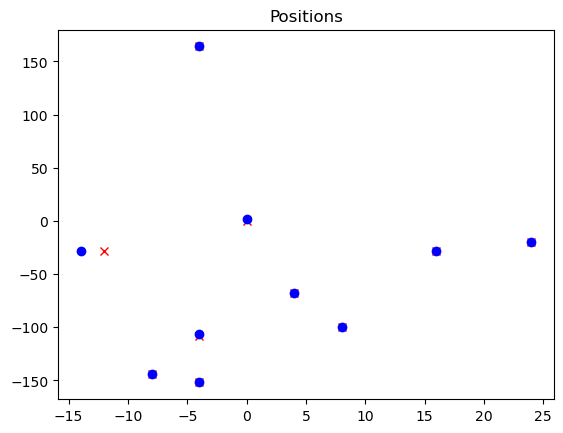

In [28]:
plt.figure()
plt.title("Positions")
plt.plot(afs0.shifts[:,0]*4, afs0.shifts[:,1]*4, 'rx')
plt.plot(afs1.shifts[:,0]*2, afs1.shifts[:,1]*2, 'bo')
plt.show()

### Run stitching algorithm at original resolution

In [30]:
afs2 = afstitch.AlignFactorStitch(data, shifts=afs1.shifts*2, scalar=flat, mask=mask, max_shift=20)
afs2.solve(refine_scalar=False, max_iter=5)

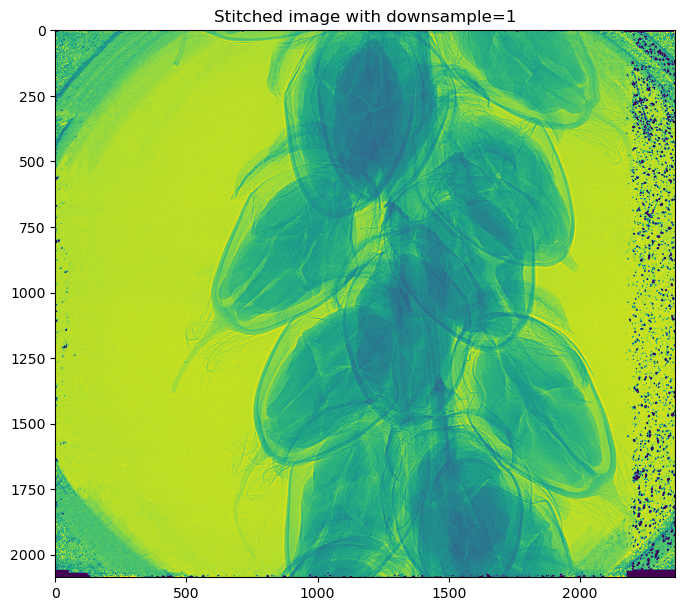

In [35]:
plt.figure(figsize=(8,8))
plt.title("Stitched image with downsample=1")
plt.imshow(afs2.stitched, vmin=np.percentile(afs2.stitched,1), vmax=np.percentile(afs2.stitched,99))
plt.show()

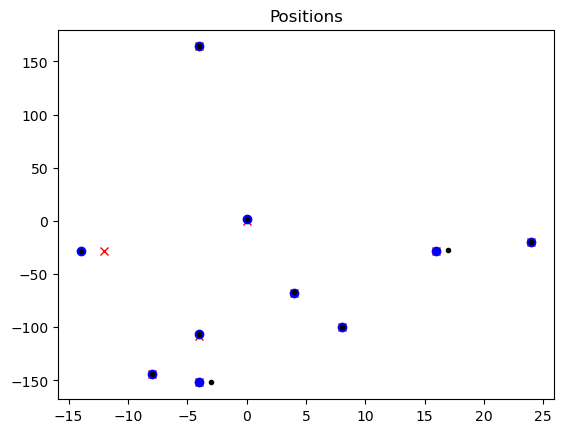

In [34]:
plt.figure()
plt.title("Positions")
plt.plot(afs0.shifts[:,0]*4, afs0.shifts[:,1]*4, 'rx')
plt.plot(afs1.shifts[:,0]*2, afs1.shifts[:,1]*2, 'bo')
plt.plot(afs2.shifts[:,0]*1, afs2.shifts[:,1]*1, 'k.')
plt.show()